In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
from os import getcwd
from pathlib import Path
from sys import path

# Set Functions to Path
full_path = os.getcwd()
functions_path = join( Path(full_path).parents[0].parents[0].parents[0] )
path.append( functions_path  )

from utils.utils import *
from ML.label_methods import *
from ETL.ETL_func import *
from datetime import datetime
import os
import logging
import dateutil

In [5]:
SYMBOLS

['BNBUSDT',
 'BNBBTC',
 'BTCUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'LTCUSDT',
 'XMRBTC',
 'TRXUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'IOTAUSDT',
 'MKRUSDT',
 'DOGEUSDT',
 'ETHUSDT']

# 1. Data Load

In [7]:
path_prefix = '/media/john' # "/mnt/"
#path_prefix = "/mnt"

SYMBOLS = ['BTCUSDT']

#--------------------------------------------------------------------
# Data Load
#--------------------------------------------------------------------
input_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/')
initial_date_load = datetime.today() - dateutil.relativedelta.relativedelta(days = 60)
years_filter = [2022]

dfs = []

for symbol in SYMBOLS:
    for year in years_filter:

        file_name = os.path.join(input_folder_db, f'{symbol}', f'{year}_{symbol}.parquet'  )
        print("Reading file", file_name)

        df = pd.read_parquet(file_name)
        df = df[df['Date'] >= initial_date_load].copy()
        dfs.append(df)

        del df

data = pd.concat(dfs, ignore_index = True).drop_duplicates()

data.loc[:,'timestamp'] = data['Open Time'].copy()
data.set_index('timestamp', inplace = True)
data.sort_values(by = ['timestamp'], inplace = True)

data = (data.groupby(['Ticker'], 
        group_keys= False)
        .apply(reindex_by_date)
        .reset_index())

# Convert Unix timestamp to datetime 
data.loc[:,'timestamp'] = pd.to_datetime(data['timestamp'], unit = "ms") 

Reading file /media/john/Data/Tensor_Invest_Fund/data/Cryptos/BTCUSDT/2022_BTCUSDT.parquet


In [8]:
data.tail()

,timestamp,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,Date,Year,Ticker,max_trades
85640,2022-05-05 07:30:00,1651735800000,39556.04,39578.78,39556.04,39573.87,15.35137,1651735859999,607470.125665,549,7.37715,291883.752857,0,2022-05-05 07:30:00,2022,BTCUSDT,NaN
85641,2022-05-05 07:31:00,1651735860000,39573.88,39586.36,39573.86,39585.86,11.50763,1651735919999,455470.767104,505,7.43300,294187.899591,0,2022-05-05 07:31:00,2022,BTCUSDT,NaN
85642,2022-05-05 07:32:00,1651735920000,39585.85,39585.86,39580.24,39585.03,13.62267,1651735979999,539250.730726,886,5.74058,227235.963452,0,2022-05-05 07:32:00,2022,BTCUSDT,NaN
85643,2022-05-05 07:33:00,1651735980000,39585.02,39587.31,39585.02,39587.30,15.85971,1651736039999,627833.459853,839,11.59406,458972.065463,0,2022-05-05 07:33:00,2022,BTCUSDT,NaN
85644,2022-05-05 07:34:00,1651736040000,39587.31,39587.31,39577.11,39577.11,17.36322,1651736099999,687321.632560,454,5.05216,199975.083585,0,2022-05-05 07:34:00,2022,BTCUSDT,NaN


# 2. TBM Calculation

In [40]:
#--------------------------------------------------------------------
# TBM Calculation
#--------------------------------------------------------------------

PTSL = [ [1,1], [2,2], [2,1] ] 

# Profit-Stop Loss ratio
#ptsl = [1,1]
v_barrier_minutes = 10
delta_vertical_b = pd.Timedelta(minutes = v_barrier_minutes) # Vertical barrier length 
output_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/TBM')

# Volatility Parameters
delta_volatility = pd.Timedelta(minutes=v_barrier_minutes)
span_volatility = 60

# Position Type 
# 1: Long
# -1: Short
pt = 1
n_jobs = -2
max_nbytes = '0.8M'
parallel_calculation = False

for ptsl in PTSL:

    print("Calculating labels for profit-stop ratio ", ptsl)

    for ticker in SYMBOLS:

        runtime_start = time.time()

        df_sub = data[(data['Ticker'] == ticker)].copy()

        print("Generating TBM Labels for ticker", ticker)
        print(" in the timeframe ", df_sub['Date'].min(), " - ", df_sub['Date'].max())
        print(df_sub.shape)

        df_sub = df_sub.set_index('timestamp').copy()

        try: 
            TBM_parallel = TripleBarrierMethod(df_sub, 
                                ticker,
                                ptsl, 
                                delta_vertical_b, 
                                pt, 
                                delta_volatility, 
                                span_volatility, 
                                n_jobs,
                                parallel_calculation, 
                                max_nbytes)

            TBM_parallel.run()

            print("\n")
            print(TBM_parallel.data['label'].value_counts())
            print("\n")

            TBM_parallel.store_data(output_folder_db, v_barrier_minutes)
        except Exception as e:
            logging.info(e)


        runtime = round((time.time() - runtime_start)/60, 2)
        print(f" Runtime was {runtime} minutes")


Calculating labels for profit-stop ratio  [1, 1]
Generating TBM Labels for ticker BTCUSDT
 in the timeframe  2022-03-06 11:10:00  -  2022-05-05 07:34:00
(86185, 17)
Getting volatility
Getting horizons
Getting touches


KeyboardInterrupt: 

In [42]:

df = data.copy()
df = df.set_index('timestamp').copy()

ticker = 'BTCUSDT'

# Profit-Stop Loss ratio
ptsl = [1,1]
v_barrier_minutes = 10
delta_vertical_b = pd.Timedelta(minutes = v_barrier_minutes) # Vertical barrier length 
output_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/TBM')

# Volatility Parameters
delta_volatility = pd.Timedelta(minutes=v_barrier_minutes)
span_volatility = 60 # number of candles to considered for volatility

# Position Type 
# 1: Long
# -1: Short
pt = 1
n_jobs = -2
max_nbytes = '0.8M'
parallel_calculation = False

TBM_labels = TripleBarrierMethod(df, 
                                ticker,
                                ptsl, 
                                delta_vertical_b, 
                                pt, 
                                delta_volatility, 
                                span_volatility, 
                                n_jobs,
                                parallel_calculation, 
                                max_nbytes )

TBM_labels.run()



Getting volatility
Getting horizons
Getting touches
Getting Labels


In [43]:
TBM_labels.data

,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,Date,Year,Ticker,max_trades,threshold,t1,label
timestamp,,,,,,,,,,,,,,,,,,,
2022-03-06 11:22:00,1646565720000,38154.35,38163.85,38112.19,38126.61,57.30593,1646565779999,2.185316e+06,1201,22.67825,8.648775e+05,0,2022-03-06 11:22:00,2022,BTCUSDT,1201.0,0.000859,2022-03-06 11:32:00,1
2022-03-06 11:23:00,1646565780000,38126.60,38176.11,38126.60,38157.44,47.55494,1646565839999,1.814311e+06,826,13.57070,5.177672e+05,0,2022-03-06 11:23:00,2022,BTCUSDT,826.0,0.000650,2022-03-06 11:33:00,-1
2022-03-06 11:24:00,1646565840000,38157.45,38176.10,38134.67,38156.76,18.10218,1646565899999,6.906321e+05,630,7.97198,3.041115e+05,0,2022-03-06 11:24:00,2022,BTCUSDT,630.0,0.000837,2022-03-06 11:34:00,1
2022-03-06 11:25:00,1646565900000,38156.76,38167.11,38137.65,38158.41,9.37180,1646565959999,3.575725e+05,500,4.21389,1.607706e+05,0,2022-03-06 11:25:00,2022,BTCUSDT,500.0,0.000758,2022-03-06 11:35:00,1
2022-03-06 11:26:00,1646565960000,38158.42,38170.00,38126.24,38131.79,11.35514,1646566019999,4.332036e+05,565,6.06967,2.315489e+05,0,2022-03-06 11:26:00,2022,BTCUSDT,565.0,0.000688,2022-03-06 11:36:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25 15:00:00,1648220400000,44865.45,44882.00,44783.84,44785.50,50.98212,1648220459999,2.285109e+06,1125,11.02300,4.941304e+05,0,2022-03-25 15:00:00,2022,BTCUSDT,1125.0,0.002043,2022-03-25 15:10:00,0
2022-03-25 15:01:00,1648220460000,44785.49,44801.96,44745.79,44760.25,50.18550,1648220519999,2.246921e+06,1245,21.35580,9.560665e+05,0,2022-03-25 15:01:00,2022,BTCUSDT,1245.0,0.002091,2022-03-25 15:11:00,0
2022-03-25 15:02:00,1648220520000,44760.25,44790.00,44747.00,44753.00,35.93973,1648220579999,1.608897e+06,956,13.15725,5.890367e+05,0,2022-03-25 15:02:00,2022,BTCUSDT,956.0,0.002131,2022-03-25 15:12:00,0


# Check Labels Distribution

In [45]:
data_path = '/mnt/Data/Tensor_Invest_Fund/data/Cryptos/TBM/BTCUSDT/Tripe_Barrier_Method_BTCUSDT_ptsl_1-1_vb_15m.parquet'

In [46]:
df = pd.read_parquet(data_path)

In [47]:
df['Close']

timestamp
2022-03-06 11:27:00    38169.99
2022-03-06 11:28:00    38186.27
2022-03-06 11:29:00    38215.78
2022-03-06 11:30:00    38250.00
2022-03-06 11:31:00    38252.90
                         ...   
2022-03-25 14:55:00    44852.99
2022-03-25 14:56:00    44827.91
2022-03-25 14:57:00    44846.00
2022-03-25 14:58:00    44865.99
2022-03-25 14:59:00    44865.46
Name: Close, Length: 27573, dtype: float64

In [48]:
df['Close'].index.searchsorted(df.Close.index - pd.Timedelta(minutes = 1))

array([    0,     0,     1, ..., 27569, 27570, 27571])

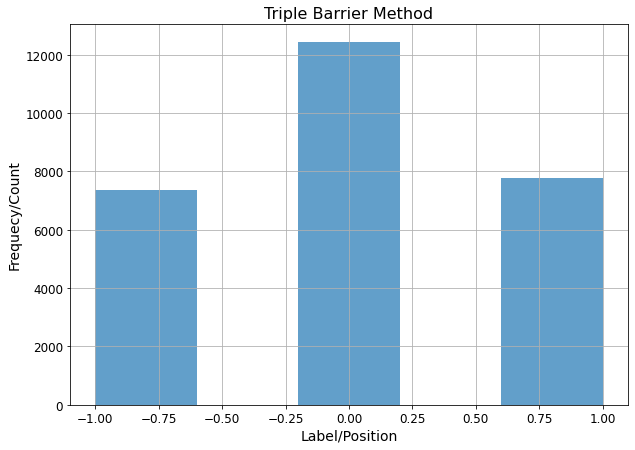

In [49]:
# Define the figure size for the plot
plt.figure(figsize=(10, 7))

# Define the label for the title of the figure
plt.title("Triple Barrier Method", fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel("Label/Position", fontsize=14)
plt.ylabel("Frequecy/Count", fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

# plotting the historgram
plt.hist(df['label'], bins=5, alpha=0.7)

plt.show()